In [20]:
import pandas as pd
import networkx as nx
from shapely import distance
def get_distance_matrix(graph:nx.DiGraph,nodes_from:[],nodes_to:[],path = False) -> (pd.DataFrame,pd.DataFrame|None):
    def heuristic(node1, node2):
        node1=new_graph.nodes[node1]
        node2=new_graph.nodes[node2]
        point1 = Point(node1['x'], node1['y'])
        point2 = Point(node2['x'], node2['y'])
        return distance(point1, point2)
    distance_matrix = pd.DataFrame(0, index=nodes_from, columns=nodes_to).astype(object)
    if path:
        route_matrix = pd.DataFrame(index=nodes_from, columns=nodes_to)
    for source in tqdm(nodes_from, total=len(nodes_from),desc = "Calculating distances"):
        for dest in nodes_to:
            path = nx.astar_path(graph,source,dest,heuristic,weight='length_meter')
            total_distance = sum(graph[path[i]][path[i + 1]]['length_meter'] for i in range(len(path) - 1))
            if path:
                route_matrix.loc[source,dest] = path
            distance_matrix.loc[source,dest] = total_distance
    if path:
        return distance_matrix,route_matrix
    return distance_matrix

In [1]:
import geopandas as gpd

stops_gdf = gpd.read_file("stopsLO.geojson")
stops_gdf.rename(columns={"Автоб": "route"}, inplace=True)
stops_gdf.dropna(subset="route", axis=0, inplace=True, how="any")
stops_gdf


,name,route,geometry
0,Дусьево,"593,593/596,847,856,860,860Л,864,865,865Д,867,...",POINT (31.72832 59.93558)
1,None,247,POINT (32.44568 59.28601)
2,Горная Шальдиха,"588,589,590,593,593/594",POINT (31.46034 59.87465)
3,Мучихино,590,POINT (31.52410 59.86666)
4,Васильково,590,POINT (31.58237 59.87627)
...,...,...,...
8386,\nЗаостровье,94,POINT (33.27731 60.62779)
8387,\nЗаостровье,94,POINT (33.27741 60.62765)
8388,Горка,94,POINT (33.22445 60.63948)
8389,Новая Слобода,"89А,91",POINT (33.33512 60.78394)


In [2]:
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
unique_routes = set()
for index, row in (stops_gdf.iterrows()):
    for i in str(row["route"]).replace('.', ',').rstrip().lstrip().split(","):
        if i != "":
            unique_routes.add(i.lstrip().rstrip())
unique_routes = pd.DataFrame(index=list(unique_routes))
unique_routes["geometry"] = [[]] * len(unique_routes)
for index, row in (stops_gdf.iterrows()):
    for i in str(row["route"]).replace('.', ',').rstrip().lstrip().split(","):
        if i != "":
            unique_routes.loc[i.lstrip().rstrip(), "geometry"] = unique_routes.loc[i.lstrip().rstrip()]["geometry"] + [
                row["geometry"]]

unique_routes

,geometry
195,"[POINT (30.197785 59.7842267), POINT (30.18284..."
348,"[POINT (29.93926291249601 59.834758554893504),..."
66/67,"[POINT (28.7021229 59.4006375), POINT (28.7004..."
611,"[POINT (30.3591211 60.3698562), POINT (30.3583..."
2342,"[POINT (29.9698833 60.7031999), POINT (30.1937..."
...,...
93Б,"[POINT (28.1929002 59.0232657), POINT (28.2963..."
76/82,"[POINT (28.7021229 59.4006375), POINT (28.7004..."
869,"[POINT (31.7283236 59.9355753), POINT (32.1405..."
925,"[POINT (29.810541270201917 58.54161355425774),..."


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from shapely import Point
import numpy as np


def clusterize(loc) -> pd.DataFrame:
    data = np.array([[p.x, p.y] for p in loc["geometry"]])
    noise = np.array([31.212390, 58.611219])
    data = np.append(data, [noise], axis=0)

    best_silhouette = -1
    best_labels = None
    k_values = range(2, 10 if len(data) > 10 else 2)

    for k in k_values:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        labels = kmeans.labels_
        silhouette = silhouette_score(data, labels)
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_labels = labels

    data = data[:-1]
    if best_labels is not None:
        best_labels = best_labels[:-1]

    if best_silhouette < 0.93:
        best_labels = [0 for _ in range(0, len(data))]
    data = pd.DataFrame({
        'label': best_labels,
        'geometry': [Point(p[0], p[1]) for p in data]
    })
    grouped_data = data.groupby('label')['geometry'].apply(list)
    grouped_data = pd.DataFrame(grouped_data)
    grouped_data.index = grouped_data.index + 1
    return grouped_data



In [4]:
devided_routes = pd.DataFrame()
basic_routes = pd.DataFrame()
for index, row in tqdm(unique_routes.iterrows(), total=unique_routes.shape[0]):
    clusterized = clusterize(row)
    if clusterized.shape[0] > 1:
        clusterized.index = index + "." + clusterized.index.astype(str)
        devided_routes = pd.concat([devided_routes, clusterized])
    else:
        clusterized.index = [index]
        basic_routes = pd.concat([basic_routes, clusterized])
devided_routes

  0%|          | 0/593 [00:00<?, ?it/s]

,geometry
label,
29.1,[POINT (30.127198170843485 59.560888275744304)...
29.2,"[POINT (32.2336435 59.9436383), POINT (32.1553..."
130.1,"[POINT (29.81278251248507 58.5457763955223), P..."
130.2,"[POINT (28.7409286 60.6878476), POINT (28.7393..."
53.1,"[POINT (28.5917039 59.4084047), POINT (28.6231..."
...,...
147.2,"[POINT (30.197785 59.7842267), POINT (30.18284..."
147.3,"[POINT (28.679680495239083 60.74368425782026),..."
147.4,[POINT (29.994139821230778 58.553770608574986)...


In [10]:
row = devided_routes.loc["8.3"]
city_crs = 32636
geometry_list = row["geometry"]
test_gdf = gpd.GeoDataFrame(data={"label": ["8.3" for _ in geometry_list], "geometry": geometry_list})
test_gdf = test_gdf.set_crs(4326)
test_gdf = test_gdf.to_crs(city_crs)
test_gdf = test_gdf.reset_index()
test_gdf


,index,label,geometry
0,0,8.3,POINT (316646.610 6514483.163)
1,1,8.3,POINT (317519.412 6514106.930)
2,2,8.3,POINT (317663.599 6514682.084)
3,3,8.3,POINT (317656.452 6515037.918)
4,4,8.3,POINT (317817.879 6515489.241)
5,5,8.3,POINT (317431.130 6514889.561)
6,6,8.3,POINT (317328.323 6514502.463)
7,7,8.3,POINT (317246.746 6514211.284)
8,8,8.3,POINT (317505.902 6515612.571)
9,9,8.3,POINT (316028.091 6515690.731)


project stops and create new graph

In [11]:
import networkx as nx
import osmnx as ox
from shapely import from_wkt, LineString, Point

nx_graph = nx.read_graphml("graph_for_test.graphml")
for i in nx_graph.edges(data=True):
    i[2]['geometry'] = from_wkt(str(i[2]['geometry']))
gdf_nodes, gdf_edges = ox.graph_to_gdfs(nx_graph)
gdf_edges: gpd.GeoDataFrame = gdf_edges.reset_index()
gdf_buffer = gdf_edges.copy()
gdf_buffer["geometry"] = gdf_buffer["geometry"].apply(lambda x: LineString(x).buffer(-3, single_sided=True))
join = gpd.sjoin_nearest(test_gdf, gdf_buffer, distance_col="dist", how="inner")
join

,index,label,geometry,index_right,u,v,key,length_meter,type,time_min,dist
0,0,8.3,POINT (316646.610 6514483.163),370,63,42,0,200.473,car,0.71,3.806132
1,1,8.3,POINT (317519.412 6514106.930),32,2,150,0,236.390,car,0.83,4.829858
2,2,8.3,POINT (317663.599 6514682.084),202,19,4,0,184.469,car,0.65,3.319083
3,3,8.3,POINT (317656.452 6515037.918),234,314,8,0,112.972,car,0.40,14.377155
4,4,8.3,POINT (317817.879 6515489.241),87,18,22,0,372.057,car,1.31,1.010399
5,5,8.3,POINT (317431.130 6514889.561),64,5,219,0,131.615,car,0.46,5.770847
6,6,8.3,POINT (317328.323 6514502.463),70,219,149,0,614.199,car,2.17,8.316723
7,7,8.3,POINT (317246.746 6514211.284),926,149,1,0,232.238,car,0.82,8.156357
8,8,8.3,POINT (317505.902 6515612.571),219,21,274,0,177.763,car,0.63,25.440546
9,9,8.3,POINT (316028.091 6515690.731),256,26,360,0,362.026,car,1.28,4.566709


In [12]:
points = pd.DataFrame(data=None)
for index, row in join.iterrows():
    point: Point = row["geometry"]
    edges_to_delete, start, end = row[["index_right", "u", "v"]]
    line: LineString = gdf_edges.loc[edges_to_delete, "geometry"]
    nearest_point = line.interpolate(line.project(point))
    data = (str(edges_to_delete) + '_' + row["label"], start, end)
    points = pd.concat(
        [points, pd.DataFrame(
            {"edge": [data], "geometry": [nearest_point]})])
points = points.groupby('edge')['geometry'].apply(list).reset_index()
# points = gpd.GeoDataFrame(data=points,geometry="geometry",crs=city_crs)
# points.to_file("projected_normalized.geojson")
points

,edge,geometry
0,"(1033_8.3, 200, 357)",[POINT (316168.41619507485 6516288.538994102)]
1,"(1035_8.3, 200, 209)","[POINT (316192.2542079082 6516359.172764772), ..."
2,"(125_8.3, 12, 76)",[POINT (317360.4248681884 6517050.096409712)]
3,"(1_8.3, 0, 264)",[POINT (316914.7157165199 6514108.4316457575)]
4,"(202_8.3, 19, 4)",[POINT (317657.4653274753 6514683.602697591)]
5,"(219_8.3, 21, 274)",[POINT (317533.25234776846 6515604.773159838)]
6,"(225_8.3, 315, 21)",[POINT (317683.3525301027 6515710.593385909)]
7,"(234_8.3, 314, 8)",[POINT (317640.1687647791 6515043.985640216)]
8,"(244_8.3, 96, 75)",[POINT (316995.21702391224 6515411.257270565)]
9,"(256_8.3, 26, 360)",[POINT (316030.59804009995 6515697.870688187)]


In [16]:
from shapely import Point
from shapely.ops import split

new_graph: nx.MultiDiGraph = nx_graph.copy()
route_nodes = []
for _, row in points.iterrows():
    label, start, end = row["edge"]
    new_points = (row['geometry'].copy())
    postfix = 1
    current_edge = new_graph.get_edge_data(start, end)[0]['geometry']
    current_node = nx_graph.nodes[start]
    current_node = Point(current_node['x'], current_node['y'])
    length = len(new_points)

    while len(new_points) > 0:
        new_node = min(new_points, key=current_node.distance)

        new_node_name = label + (('_' + str(postfix)) if length > 1 else "")
        route_nodes.append((new_node_name,start, end))
        new_graph.add_node(new_node_name, x=new_node.x, y=new_node.y, desc="bus_stop")

        first, _, second = split(current_edge, new_node.buffer(0.0001)).geoms

        new_edge = LineString(list(first.coords[:-1]) + list(new_node.coords))
        new_graph.add_edge(start, new_node_name, length_meter=new_edge.length, geometry=new_edge)

        start = new_node_name
        current_edge = LineString(list(new_node.coords) + list(second.coords[1:]))
        current_node = new_node
        new_points.remove(new_node)
        postfix = postfix + 1
    
    new_graph.add_edge(new_node_name, end, length_meter=current_edge.length, geometry=current_edge)
route_nodes

[('1033_8.3', '200', '357'),
 ('1035_8.3_1', '200', '209'),
 ('1035_8.3_2', '1035_8.3_1', '209'),
 ('125_8.3', '12', '76'),
 ('1_8.3', '0', '264'),
 ('202_8.3', '19', '4'),
 ('219_8.3', '21', '274'),
 ('225_8.3', '315', '21'),
 ('234_8.3', '314', '8'),
 ('244_8.3', '96', '75'),
 ('256_8.3', '26', '360'),
 ('258_8.3', '357', '200'),
 ('259_8.3', '357', '26'),
 ('262_8.3', '360', '26'),
 ('284_8.3', '209', '101'),
 ('285_8.3', '209', '200'),
 ('2_8.3', '0', '41'),
 ('321_8.3', '38', '42'),
 ('324_8.3', '38', '39'),
 ('32_8.3', '2', '150'),
 ('369_8.3', '63', '59'),
 ('370_8.3', '63', '42'),
 ('467_8.3', '59', '94'),
 ('474_8.3', '94', '59'),
 ('527_8.3', '75', '96'),
 ('547_8.3', '101', '209'),
 ('64_8.3', '5', '219'),
 ('70_8.3', '219', '149'),
 ('714_8.3', '123', '190'),
 ('84_8.3', '274', '7'),
 ('872_8.3', '190', '123'),
 ('876_8.3', '126', '167'),
 ('87_8.3', '18', '22'),
 ('926_8.3', '149', '1')]

In [67]:
nodes_to_save = set(list(sum(route_nodes,())))
nonstop = list(nodes_to_save^set([i[0] for i in route_nodes]))
new_graph = nx.DiGraph(new_graph)
dist_matrix,path_nodes = get_distance_matrix(new_graph,nonstop,nonstop,True)

Calculating distances:   0%|          | 0/39 [00:00<?, ?it/s]

In [68]:
temp_subgraph = nx.Graph(new_graph.subgraph(nonstop))
for island in list(nx.connected_components(temp_subgraph)):
    for u in island:
        for v in island:
            if u!=v:
                if nx.has_path(temp_subgraph,u,v):
                    dist_matrix.loc[u,v] = float("inf")
dist_matrix

,274,94,76,209,4,314,1,126,18,200,...,101,59,12,360,0,264,26,39,21,42
274,0,2719.056,3753.643,4687.715,1137.038,inf,1699.957,3257.056,inf,5108.914,...,3858.369,2664.295,3362.461,4144.652,2050.638,1842.237,4506.678,2391.638,inf,2538.884
94,3014.692,0,2231.05,2835.058,2106.58,2273.681,1067.74,538.0,2549.734,2401.056,...,2330.261,inf,2622.232,1436.794,668.418,876.819,1798.82,inf,3192.455,inf
76,3768.033,2231.05,0,inf,4326.432,4236.943,3287.592,1807.403,3958.1,inf,...,inf,2274.613,inf,inf,2888.27,3096.671,inf,2714.913,3591.855,2557.564
209,4702.105,2835.058,inf,0,4930.44,5097.541,3891.6,2411.411,4892.172,inf,...,inf,2878.621,inf,inf,3492.278,3700.679,inf,3231.094,4525.927,3086.455
4,1104.948,2150.564,4273.853,4974.424,0,363.937,1129.955,2688.564,639.99,4540.422,...,4378.579,2095.803,3882.671,3576.16,1482.146,1273.745,3938.186,1823.146,1282.711,1970.392
314,inf,2273.681,3909.916,4843.988,691.663,0,1254.582,2811.681,inf,4663.539,...,4014.642,2218.92,3518.734,3699.277,1605.263,1396.862,4061.303,1946.263,inf,2093.509
1,2202.638,1067.74,3287.592,3891.6,1097.69,1461.627,0,1605.74,1737.68,3457.598,...,3386.803,1012.979,3678.774,2493.336,399.322,190.921,2855.362,740.322,2380.401,887.568
126,3552.692,538.0,1807.403,2411.411,2644.58,2811.681,1605.74,0,3087.734,1977.409,...,1906.614,718.966,2170.048,1013.147,1206.418,1414.819,1375.173,1237.231,3730.455,1079.882
18,inf,2555.672,3633.863,4567.935,973.654,inf,1536.573,3093.672,0,4945.53,...,3738.589,2500.911,3242.681,3981.268,1887.254,1678.853,4343.294,2228.254,inf,2375.5
200,5136.107,2401.056,inf,inf,4496.438,4663.539,3457.598,1977.409,4939.592,0,...,inf,2444.619,inf,inf,3058.276,3266.677,inf,2797.092,4959.929,2652.453


In [74]:
iter_ = 0
nonstop = list(nodes_to_save^set([i[0] for i in route_nodes]))
subgraph = nx.DiGraph(new_graph.subgraph(nonstop))
while len(list(nx.strongly_connected_components(subgraph))) > 1:
    print(len(list(nx.strongly_connected_components(subgraph))))
    min_dist = float("inf")
    min_path = []
    for node in min(nx.strongly_connected_components(subgraph),key=len):
        try:
            row = dist_matrix.loc[node].drop(node)
            min_dist_ = row.min()
            min_dist_column = row.idxmin()
            if min_dist_<min_dist:
                min_dist = min_dist_
                min_path = path_nodes.loc[node][min_dist_column]
                dist_matrix.loc[node,min_dist_column] = float("inf")
        except KeyError:
            pass
    for node in min_path:
        nonstop.append(node)
    subgraph = nx.DiGraph(new_graph.subgraph(nonstop))
    print(min_dist)
    print(min_path)
    
    
    

for i in subgraph.edges(data=True):
    i[2]['geometry'] = str(i[2]['geometry'])
nx.write_graphml(subgraph,"subgraph_2.graphml")


15
283.518
['4', '168', '219']
13
190.921
['1', '151', '264']
12
395.478
['8', '6', '232', '5']
10
265.09999999999997
['5', '24', '23', '314']
9
468.106
['2', '291', '1', '151', '264']
7
292.86199999999997
['126', '470', '25', '96']
6
283.51800000000003
['219', '168', '4']
6
430.73299999999995
['4', '9', '512', '24', '5']
5
232.025
['39', '40', '41']
4
217.869
['75', '99', '123']
3
190.921
['264', '151', '1']
3
232.025
['41', '40', '39']
3
325.813
['41', '40', '39', '38']
3
325.813
['38', '39', '40', '41']
3
341.0
['0', '41', '40', '39']
3
399.322
['0', '264', '151', '1']
3
434.788
['0', '41', '40', '39', '38']
3
488.24600000000004
['0', '41', '66', '73', '42']
3
217.869
['123', '99', '75']
3
292.86199999999997
['96', '25', '470', '126']
3
323.255
['96', '25', '470', '126', '167']
3
333.297
['96', '75', '99', '123']
3
438.683
['75', '96', '25', '470', '126', '167']
3
456.7
['190', '123', '99', '75', '96']
3
456.70000000000005
['96', '75', '99', '123', '190']
3
720.285
['360', '190', '1

In [15]:
import networkx as nx

# Предположим, что G - это ваш изначальный граф, а islands - это список "островов"
nodes_to_save = list(sum(route_nodes,()))
G = nx.DiGraph(new_graph.subgraph(nodes_to_save))
islands = list(nx.strongly_connected_components(G))
new_G = nx.DiGraph()
for island in islands:
    min_distance = float('inf')
    nearest_island = None
    # Ищем ближайший "остров"
    for other_island in islands:
        if island != other_island:
            try:
                distance = nx.shortest_path_length(G, source=island, target=other_island, weight='weight')
                if distance < min_distance:
                    min_distance = distance
                    nearest_island = other_island
            except nx.NetworkXNoPath:
                continue

    # Добавляем минимальный маршрут в новый граф
    if nearest_island is not None:
        path = nx.shortest_path(G, source=island, target=nearest_island, weight='length_meter')
        new_G.add_path(path, weight=min_distance)

print(nodes_to_save)
new_G.nodes
# Теперь new_G - это граф, который содержит минимальные маршруты между "островами"


NodeNotFound: Node {'274', '22', '7', '84_8.3', '225_8.3', '21', '219_8.3', '315', '18', '87_8.3'} not found in graph

In [39]:
nodes_to_save = sum(route_nodes,())
subgraph = nx.DiGraph(new_graph.subgraph(nodes_to_save))
for i in subgraph.edges(data=True):
    i[2]['geometry'] = str(i[2]['geometry'])
nx.write_graphml(subgraph,"subgraph_2.graphml")

In [20]:

route_nodes_ind=[x[0] for x in route_nodes]
distance_matrix,route_matrix = get_distance_matrix(subgraph,route_nodes_ind,route_nodes_ind,True)
max_value = distance_matrix.values.max()
for i in route_nodes:
    node_1,n1_1,n2_1 = i
    for j in route_nodes:
        node_2,n1_2,n2_2 = j
        if (n1_1,n2_1) == (n2_2,n1_2):
            distance_matrix.loc[node_1, node_2]=max_value
distance_matrix

Calculating distances:   0%|          | 0/34 [00:00<?, ?it/s]

,1033_8.1,1035_8.1_1,1035_8.1_2,125_8.1,1_8.1,202_8.1,219_8.1,225_8.1,234_8.1,244_8.1,...,527_8.1,547_8.1,64_8.1,70_8.1,714_8.1,84_8.1,872_8.1,876_8.1,87_8.1,926_8.1
1033_8.1,0,890.988563,1097.459787,2748.796569,7875.954121,7160.168221,5968.849631,5713.468247,6483.560813,1737.437252,...,1656.485529,2268.248187,6522.727492,6922.844668,1357.358651,6004.863875,1304.210594,8999.14795,6407.571345,7224.373304
1035_8.1_1,894.131322,0,206.471224,1858.725149,6985.882701,6270.096801,5078.778211,4823.396826,5593.489393,2630.699832,...,2549.748109,1378.176767,5632.656072,6032.773248,2250.621231,5114.792455,2197.473174,8109.07653,5517.499925,6334.301884
1035_8.1_2,687.660098,662.449919,0,1652.253925,6779.411477,6063.625577,4872.306987,4616.925603,5387.018169,2424.228608,...,2343.276885,1171.705543,5426.184848,5826.302025,2044.150008,4908.321231,1991.00195,7902.605307,5311.028701,6127.83066
125_8.1,1686.646668,1661.43649,1867.907713,0,5910.254047,5194.468148,4003.149557,3747.768173,4517.86074,3423.215178,...,3342.263455,512.000113,4557.027419,4957.144595,3043.136578,4039.163802,2989.988521,7033.447877,4441.871272,5258.67323
1_8.1,6836.053023,6810.842844,7017.314068,5150.13885,0,1284.058502,2569.558912,2357.587528,1520.408094,8572.621533,...,8491.66981,5661.406468,1559.574773,1950.070949,8192.542932,2251.632156,8139.394875,1540.697231,1999.314626,516.468585
202_8.1,5749.175116,5723.964937,5930.436161,4063.260943,1637.295495,0,1482.681005,1270.70962,433.530187,7485.743626,...,7404.791903,4574.528561,561.388866,682.676042,7105.665025,1164.754249,7052.516968,2760.489324,912.436719,984.204678
219_8.1,5207.098717,5181.888539,5388.359762,3521.184544,2183.921096,1468.135197,0,417.813222,791.527789,6943.667227,...,6862.715504,4032.452162,830.694467,1230.811644,6563.588627,37.93985,6510.440569,3307.114926,715.53832,1532.340279
225_8.1,5107.154971,5081.944792,5288.416016,3421.240798,2439.50335,1723.71745,255.92286,0,1047.110042,6843.723481,...,6762.771758,3932.508416,1086.276721,1486.393897,6463.64488,293.522104,6410.496823,3562.697179,971.120574,1787.922533
234_8.1,5315.864957,5290.654778,5497.126002,3629.950784,1922.959336,1207.173436,1049.370845,837.399461,0,7052.433467,...,6971.481744,4141.218402,569.732707,969.849883,6672.354866,731.44409,6619.206809,3046.153165,479.12656,1271.378519
244_8.1,1737.335569,1712.125391,1918.596614,3569.933396,8697.090948,7981.305049,6789.986458,6534.605074,7304.697641,0,...,9901.236501,3089.385014,7343.864319,7743.981496,286.903479,6826.000702,480.561421,9820.284778,7228.708172,8045.510131


In [21]:
route_matrix

,1033_8.1,1035_8.1_1,1035_8.1_2,125_8.1,1_8.1,202_8.1,219_8.1,225_8.1,234_8.1,244_8.1,...,527_8.1,547_8.1,64_8.1,70_8.1,714_8.1,84_8.1,872_8.1,876_8.1,87_8.1,926_8.1
1033_8.1,[1033_8.1],"[1033_8.1, 357, 200, 1035_8.1_1]","[1033_8.1, 357, 200, 1035_8.1_1, 1035_8.1_2]","[1033_8.1, 357, 200, 209, 101, 76, 12, 125_8.1]","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 26, 360, 190, 123, 99, 75, 96,...",...,"[1033_8.1, 357, 26, 360, 190, 123, 99, 75, 527...","[1033_8.1, 357, 200, 209, 101, 547_8.1]","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 26, 360, 190, 123, 714_8.1]","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 26, 360, 190, 872_8.1]","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351...","[1033_8.1, 357, 200, 209, 101, 76, 12, 14, 351..."
1035_8.1_1,"[1035_8.1_1, 1035_8.1_2, 209, 200, 1033_8.1]",[1035_8.1_1],"[1035_8.1_1, 1035_8.1_2]","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 125...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 200, 357, 26, 36...",...,"[1035_8.1_1, 1035_8.1_2, 209, 200, 357, 26, 36...","[1035_8.1_1, 1035_8.1_2, 209, 101, 547_8.1]","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 200, 357, 26, 36...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 200, 357, 26, 36...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,...","[1035_8.1_1, 1035_8.1_2, 209, 101, 76, 12, 14,..."
1035_8.1_2,"[1035_8.1_2, 209, 200, 1033_8.1]","[1035_8.1_2, 209, 200, 1035_8.1_1]",[1035_8.1_2],"[1035_8.1_2, 209, 101, 76, 12, 125_8.1]","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 200, 357, 26, 360, 190, 123,...",...,"[1035_8.1_2, 209, 200, 357, 26, 360, 190, 123,...","[1035_8.1_2, 209, 101, 547_8.1]","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 200, 357, 26, 360, 190, 123,...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 200, 357, 26, 360, 190, 872_...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1...","[1035_8.1_2, 209, 101, 76, 12, 14, 351, 276, 1..."
125_8.1,"[125_8.1, 76, 101, 209, 200, 1033_8.1]","[125_8.1, 76, 101, 209, 200, 1035_8.1_1]","[125_8.1, 76, 101, 209, 200, 1035_8.1_1, 1035_...",[125_8.1],"[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 101, 209, 200, 357, 26, 360, 190...",...,"[125_8.1, 76, 101, 209, 200, 357, 26, 360, 190...","[125_8.1, 76, 101, 547_8.1]","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 101, 209, 200, 357, 26, 360, 190...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 101, 209, 200, 357, 26, 360, 190...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14, 351, 276, 13, 11, 374, 2...","[125_8.1, 76, 12, 14

In [22]:
from dataclasses import dataclass
from math import sqrt
from math import inf
from numpy import exp
from random import random, shuffle, sample


class Base:
    """
    The base class for path finding algorithms.
    Contains common functions.
    """

   

    @staticmethod
    def _calculate_dist(dm: list[list[float]], indx: list[int]) -> float:
        """Calculates the path length based on the index list of the distance matrix."""

        dist = 0
        for i in range(len(indx) - 1):
            dist += dm[indx[i]][indx[i + 1]]
        return dist


@dataclass
class Path:
    """
    Dataclass describing a path using:
    * list of point indices;
    * path length;
    * path name (optional).
    """

    indx: list[int]
    leng: float
    name: str
    
class ACO(Base):
    """
    Ant Colony Optimization algorithm is introduced based on the foraging behavior of an ant
    for seeking a path between their colony and source food.\n
    -----
    `ants: int` THE NUMBER OF ANTS\n
    The total number of agents (ants) involved in one iteration.\n
    -----
    `iter: int` THE NUMBER OF ITERATIONS\n
    The maximum number of iterations of the algorithm.\n
    -----
    `a: float` INFORMATION ELICITATION FACTOR\n
    The information elicitation factor α, which represents the relative importance of the pheromone,
    reflects the importance of the accumulation of the pheromone with regard to the ants' path selection.\n
    -----
    `b: float` EXPECTED HEURISTIC FACTOR\n
    The expected heuristic factor β, which represents the relative importance of the visibility,
    reflects the importance of the heuristic information with regard to the ants' path selection.\n
    -----
    `p: float` PHEROMONE EVAPORATION COEFFICIENT\n
    The pheromone evaporation coefficient ρ, which represents the degree of pheromone evaporation,
    reflects the degree of mutual influence among ants. Generally, the value of  is [0, 1],
    which prevents the infinite accumulation of pheromone effectively.\n
    -----
    `q: float` PHEROMONE INTENSITY\n
    The pheromone intensity Q, which represents the total pheromone,
    affects the convergence speed of the alghoritm to a certain extent.\n
    """

    def __init__(self, ants: int, iter: int, a: float, b: float, p: float, q: float) -> None:
        """Initializes the hyperparameters for the algorithm."""

        self.ants = ants
        self.iter = iter
        self.a = a
        self.b = b
        self.p = p
        self.q = q

    @staticmethod
    def __select_i(selection: list[int]) -> int:
        """Selects a random index of the next 2D point."""

        sum_num = sum(selection)
        if sum_num == 0:
            return len(selection) - 1
        tmp_num = random()
        prob = 0
        for i in range(len(selection)):
            prob += selection[i] / sum_num
            if prob >= tmp_num:
                return i

    def __create_indx(self, dm: list[list[float]], pm: list[list[float]]) -> list[int]:
        """Creates a new ordering of 2D point indices based on the distance and pheromone."""

        l = len(dm)
        unvisited_indx = list(range(l))
        shuffle(unvisited_indx)
        visited_indx = [unvisited_indx.pop()]
        for _ in range(l - 1):
            i = visited_indx[-1]
            selection = []
            for j in unvisited_indx:
                selection.append(
                    (pm[i][j] ** self.a) * ((1 / max(dm[i][j], 10**-5)) ** self.b)
                )
            selected_i = ACO.__select_i(selection)
            visited_indx.append(unvisited_indx.pop(selected_i))
        visited_indx.append(visited_indx[0])
        return visited_indx

    def update_pm(self, pm: list[list[float]], tmp_indx: list[list[int]], tmp_leng: list[float]) -> None:
        """Updates the pheromone matrix."""

        l = len(pm)
        for i in range(l):
            for j in range(i, l):
                pm[i][j] *= 1 - self.p
                pm[j][i] *= 1 - self.p
        for i in range(self.ants):
            delta = self.q / tmp_leng[i]
            indx = tmp_indx[i]
            for j in range(l):
                pm[indx[j]][indx[j + 1]] += delta
                pm[indx[j + 1]][indx[j]] += delta

    def run(self, dm:list[list[float]], name: str = None, ) -> Path:
        """Runs the algorithm for the given 2D points."""
        l = len(dm)
        pm = [[1 for _ in range(l)] for _ in range(l)]

        res_indx = []
        res_leng = inf
        for _ in range(self.iter):
            tmp_indx = []
            tmp_leng = []
            for _ in range(self.ants):
                indx = self.__create_indx(dm, pm)
                tmp_indx.append(indx)
                tmp_leng.append(ACO._calculate_dist(dm, indx))
            self.update_pm(pm, tmp_indx, tmp_leng)
            best_leng = min(tmp_leng)
            if best_leng < res_leng:
                res_leng = best_leng
                res_indx = tmp_indx[tmp_leng.index(best_leng)]
        return Path(indx=res_indx, leng=res_leng, name=name)


22894.33746719673
['125_8.1', '547_8.1', '285_8.1', '1033_8.1', '259_8.1', '256_8.1', '872_8.1', '527_8.1', '714_8.1', '244_8.1', '262_8.1', '258_8.1', '1035_8.1_1', '1035_8.1_2', '284_8.1', '225_8.1', '219_8.1', '84_8.1', '64_8.1', '70_8.1', '926_8.1', '1_8.1', '2_8.1', '324_8.1', '321_8.1', '370_8.1', '369_8.1', '467_8.1', '876_8.1', '474_8.1', '32_8.1', '202_8.1', '234_8.1', '87_8.1', '125_8.1']


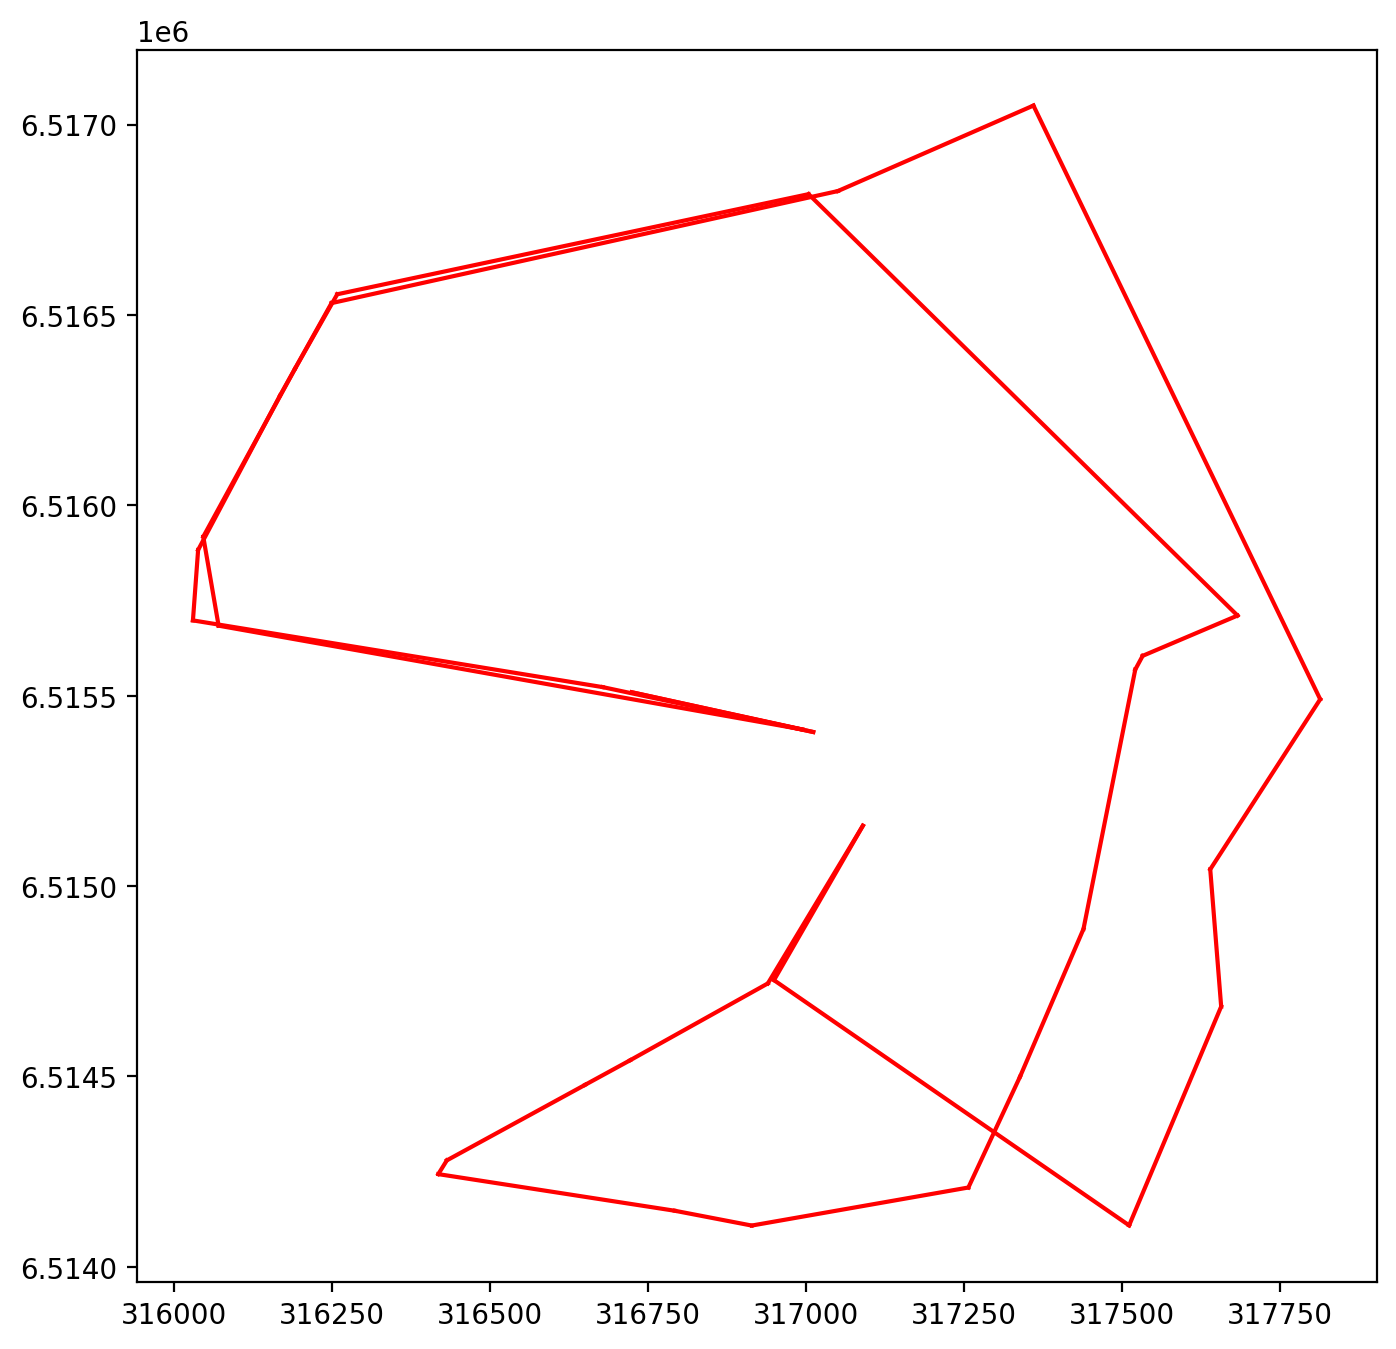

In [23]:
import matplotlib.pyplot as plt
dm = distance_matrix.values.tolist()

aco = ACO(ants=1500, iter=150, a=1.1, b=0.8, p=0.2, q=10)

result = (aco.run(dm=distance_matrix.values.tolist(), name="ACO"))
mapping = dict(zip(range(distance_matrix.shape[0]),distance_matrix.index))
print(result.leng)
path = [mapping.get(i) for i in result.indx]
print(path)   
path = [mapping.get(i) for i in result.indx]
plt.figure(figsize=(8, 8), dpi=200)
for i in range(len(path) - 1):
     node1 = new_graph.nodes[path[i]]
     node2 = new_graph.nodes[path[i+1]]
     plt.plot(*zip((node1['x'],node1['y']), (node2['x'],node2['y'])), color='red')

In [33]:
path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
full_route_nodes = []
for u,v in path_edges:
    route_ =route_matrix.loc[u,v]
    for node_ in route_[:-1]:
        full_route_nodes.append(node_)
df = pd.DataFrame()
for i in range(len(full_route_nodes) - 1):
    node1 = full_route_nodes[i]
    node2 = full_route_nodes[i + 1]
    geometry = new_graph[node1][node2]['geometry']
    temp_df = pd.DataFrame({'geometry': [geometry]})
    df = pd.concat([df,temp_df])
df = gpd.GeoDataFrame(data=df,geometry='geometry',crs=city_crs)
df.to_file("test_route.geojson")

In [104]:
import networkit as nk
from src.dongraphio.utils import matrix_utils

df = pd.DataFrame.from_dict(dict(graph_with_geom.nodes(data=True)), orient="index")
graph_gdf = gpd.GeoDataFrame(df, geometry=df["geometry"], crs=city_crs)
nearest_nodes = graph_gdf["geometry"].sindex.nearest(
    test_gdf["geometry"], return_distance=True, return_all=False
)

distance_matrix = pd.DataFrame(0, index=nearest_nodes[0][1], columns=nearest_nodes[0][1])
for source in tqdm(nearest_nodes[0][1], total=len(nearest_nodes[0][1])):
    for dest in nearest_nodes[0][1]:
        heu = None
        r = nk.distance.AStar(G=nk_graph, heu=heu, source=source, target=dest).run()


  0%|          | 0/34 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not iterable

In [ ]:
from shapely.geometry import MultiPoint

devided_routes["geometry"] = devided_routes["geometry"].apply(lambda x: MultiPoint(x))
devided_routes = gpd.GeoDataFrame(data=devided_routes, geometry="geometry")
devided_routes.to_file("new_routes.geojson")


In [6]:
from shapely import from_wkt
from src.dongraphio.utils import get_osmnx_graph
import osmnx as ox
import networkx as nx

G_drive: nx.MultiDiGraph = get_osmnx_graph(
    2705630, 32636, "drive", truncate_by_edge=False
)
nx.write_graphml(G_drive, "graph_for_test.graphml")
for i in G_drive.edges(data=True):
    i[2]['geometry'] = from_wkt(str(i[2]['geometry']))
gdf = ox.graph_to_gdfs(G_drive, nodes=False)
gdf.to_file("graph_for_test.geojson")

2024-03-18 15:58:27.231 | DEBUG    | src.dongraphio.utils.graphs:get_osmnx_graph:58 - Extracting and preparing drive graph from OSM ...


In [ ]:
class GA(Base):
    """
    Genetic algorithm is a metaheuristic inspired by the process of natural selection
    that belongs to the larger class of evolutionary algorithms.\n
    -----
     `population: int` THE NUMBER OF INDIVIDUALS\n
    The total number of individuals involved in one iteration.\n
    -----
     `iter: int` THE NUMBER OF ITERATIONS\n
    The maximum number of iterations of the algorithm.\n
    -----
     `s: float` SELECTION COEFFICIENT\n
    Determines how many of the best individuals will make it to the next population.\n
    -----
     `m: float` MUTATION COEFFICIENT\n
    Determines how often individuals in a population mutate.\n
    """

    def __init__(self, population: int, iter: int, s: float, m: float) -> None:
        """Initializes the hyperparameters for the algorithm."""

        self.population = population
        self.iter = iter
        self.s = s
        self.m = m

    @staticmethod
    def __fitness_sort(dm: list[list[float]], individuals: list[list[int]]) -> None:
        """Sorts the individuals of a given population by fit."""

        individuals.sort(key=lambda i: GA._calculate_dist(dm, i))

    def __initialization(self, l: int) -> list[list[int]]:
        """Initializes the first population of individuals."""

        base = list(range(l))
        individuals = []
        for _ in range(self.population):
            shuffle(base)
            individuals.append(base + [base[0]])
        return individuals

    def __selection(self, individuals: list[list[int]]) -> None:
        """Selects the best individuals of a given population."""

        del individuals[int(self.population * self.s) :]

    def __crossover(self, individuals: list[list[int]]) -> None:
        """Crossbreeding some individuals of a given population."""

        childs = []
        w_size = len(individuals[0]) // 2
        for _ in range(len(individuals), self.population):
            p1, p2 = sample(individuals, 2)
            childs.append(
                p1[: w_size - 1]
                + [i for i in p2[:-1] if i not in p1[: w_size - 1]]
                + [p1[0]]
            )
        individuals += childs

    def __mutation(self, individuals: list[list[int]]) -> None:
        """Mutates some individuals of a given population."""

        sampling = list(range(1, len(individuals[0]) - 1))
        for item in individuals:
            if random() < self.m:
                i, j = sample(sampling, 2)
                item[i], item[j] = item[j], item[i]

    def run(self, dm:list[list[float]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(dm)
        individuals = self.__initialization(l)
        for _ in range(self.iter):
            GA.__fitness_sort(dm, individuals)
            self.__selection(individuals)
            self.__crossover(individuals)
            self.__mutation(individuals)
        GA.__fitness_sort(dm, individuals)
        return Path(indx=individuals[0], leng=GA._calculate_dist(dm, individuals[0]), name=name)

class SA(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    -----
    `iter: int` THE NUMBER OF ITERATIONS\n
    The maximum number of iterations of the algorithm.\n
    -----
    `t: int` INITIAL TEMPERATURE\n
    The initial temperature for the search decreases with the progress of the search.\n
    -----
    `g: float` CHANGE COEFFICIENT\n
    The coefficient affecting temperature change.\n
    """

    def __init__(self, iter: int, t: int, g: float) -> None:
        """Initializes the hyperparameters for the algorithm."""

        self.iter = iter
        self.t = t
        self.g = g

    def __is_acceptable(self, prb_leng: float, tmp_leng: float) -> bool:
        """Checks if the state transition will execute."""

        prob = min(1, exp(-(prb_leng - tmp_leng) / self.t))
        if prob > random():
            return True
        return False

    def run(self, dm:list[list[float]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""
        l = len(dm)
        tmp_indx = [i for i in range(l)] + [0]
        tmp_leng = SA._calculate_dist(dm, tmp_indx)
        res_indx = tmp_indx.copy()
        res_leng = tmp_leng
        for _ in range(self.iter):
            i, j = sample(range(1, l), 2)
            prb_indx = tmp_indx.copy()
            prb_indx[i], prb_indx[j] = prb_indx[j], prb_indx[i]
            prb_leng = SA._calculate_dist(dm, prb_indx)
            if self.__is_acceptable(prb_leng, tmp_leng):
                tmp_indx = prb_indx
                tmp_leng = prb_leng
            if tmp_leng < res_leng:
                res_indx = tmp_indx
                res_leng = tmp_leng
            self.t *= self.g
        return Path(indx=res_indx, leng=res_leng, name=name)


In [ ]:
import matplotlib.pyplot as plt

dm = distance_matrix.replace(0,1).values.tolist()
sa = SA(iter=100000, t=10000, g=0.6)
result = sa.run(dm=dm, name="SA")
mapping = dict(zip(range(distance_matrix.shape[0]),distance_matrix.index))
print(result.leng)
path = [mapping.get(i) for i in result.indx]
for i in range(len(path) - 1):
     node1 = new_graph.nodes[path[i]]
     node2 = new_graph.nodes[path[i+1]]
     plt.plot(*zip((node1['x'],node1['y']), (node2['x'],node2['y'])), color='red')
     


In [ ]:
import matplotlib.pyplot as plt
dm = distance_matrix.values.tolist()

ga = GA(population=4000, iter=2000, s=0.4, m=0.8)
result = (ga.run(dm=dm, name="GA"))
mapping = dict(zip(range(distance_matrix.shape[0]),distance_matrix.index))
print(result.leng)
path = [mapping.get(i) for i in result.indx]
for i in range(len(path) - 1):
     node1 = new_graph.nodes[path[i]]
     node2 = new_graph.nodes[path[i+1]]
     plt.plot(*zip((node1['x'],node1['y']), (node2['x'],node2['y'])), color='red')